In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import cv2
import glob
from keras.utils import plot_model

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7727054168433541077
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1446540749225749106
physical_device_desc: "device: 0, name: NVIDIA Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5"
]


In [3]:
# DeepFashion Dataset Path
train_path = '/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/train'
validation_path = '/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/validation'
test_path = '/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/test'

# Setting the Parameters & Hyperparameters

# 1
# img_row, img_col, img_channel = 224, 224, 3
# batch_size_train = 32
# batch_size_validation = 32
# epochs = 10
# category_nums = 50
# drop_rate = 0.25
# learning_rate = 0.001
# momentum_num = 0.99
# plot_num_rows = 3
# plot_num_rows = 3

# # 2
# img_row, img_col, img_channel = 224, 224, 3
# batch_size_train = 64
# batch_size_validation = 64
# epochs = 20
# category_nums = 50
# drop_rate = 0.25
# learning_rate = 0.0001
# momentum_num = 0.99
# plot_num_rows = 3
# plot_num_rows = 3

# 3
img_row, img_col, img_channel = 224, 224, 3
batch_size_train = 64
batch_size_validation = 64
epochs = 3
category_nums = 50
drop_rate = 0.25
learning_rate = 0.0001
momentum_num = 0.99
plot_num_rows = 3
plot_num_rows = 3

In [4]:
# Initialize the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(img_row, img_col, img_channel))

# Freeze all the layers
for layer in vgg_conv.layers[:]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f2cfeb76a58> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2d9453ed68> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2cf0163630> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2cf0113e48> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2cf011bc50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2cf011b3c8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2cf0123dd8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2cf012af28> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2cf00b0048> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f2cf00b73c8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f2cf00ba8d0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [5]:
def build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num):
    
    # Create the model
    model = tf.keras.models.Sequential()

    # Add the vgg convolutional base model
    model.add(vgg_conv)

    # Add new layers
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(drop_rate))
    model.add(Dense(category_nums, activation='softmax'))

    # Compile the model with a SGD and a very slow learning rate
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [6]:
model = build_model(vgg_conv, category_nums, drop_rate, learning_rate, momentum_num)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                51250     
Total params: 40,461,170
Trainable params: 25,744,434
Non-trainable params: 14,716,736
___________________________________

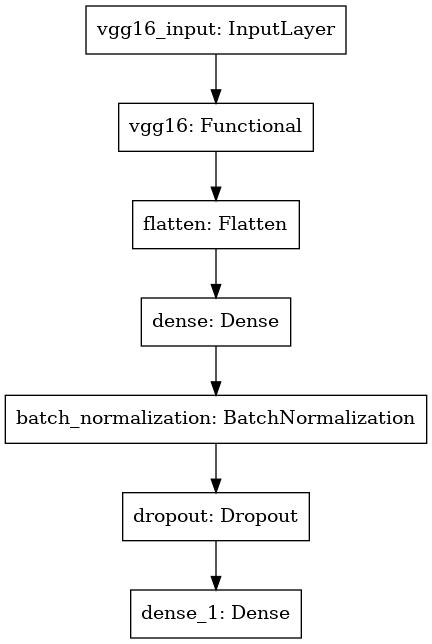

In [8]:
# Show a summary of the model
plot_model(model, to_file='/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/plot/model_summary.jpg')

In [9]:
def data_load(train_path, validation_path, test_path, batch_size_train, batch_size_validation, img_row, img_col):

    # Train
    imgdatagen_train = ImageDataGenerator(
        rescale=1./255
    )

    train_dataset = imgdatagen_train.flow_from_directory(
        train_path,
        target_size=(img_row, img_col),
        batch_size=batch_size_train,
        classes = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress'],
        shuffle=True
    )

    # Validation
    imgdatagen_validatioin = ImageDataGenerator(
        rescale=1./255
    )

    validation_dataset = imgdatagen_validatioin.flow_from_directory(
        validation_path,
        target_size=(img_row, img_col),
        batch_size=batch_size_validation,
        classes = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress'],
        shuffle=True
    )

    # Test
    imgdatagen_test = ImageDataGenerator(
        rescale=1./255
    )
    
    test_dataset = imgdatagen_test.flow_from_directory(
        test_path,
        target_size=(img_row, img_col),
        classes = ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress'],
        shuffle=True
    )
    
    return train_dataset, validation_dataset, test_dataset

In [10]:
train_dataset, validation_dataset, test_dataset = data_load(train_path, validation_path, test_path, batch_size_train, batch_size_validation, img_row, img_col)

X_train, y_train = next(train_dataset)

print(X_train.shape)
print(y_train.shape)

X_val, y_val = next(validation_dataset)

print(X_val.shape)
print(y_val.shape)

X_test, y_test = next(test_dataset)

print(X_test.shape)
print(y_test.shape)

Found 209222 images belonging to 50 classes.
Found 40000 images belonging to 50 classes.
Found 40000 images belonging to 50 classes.
(64, 224, 224, 3)
(64, 50)
(64, 224, 224, 3)
(64, 50)
(32, 224, 224, 3)
(32, 50)


In [11]:
class_labels = list(validation_dataset.class_indices.keys())
num_imgs_validation = len(validation_dataset.filenames)
num_imgs_train = len(train_dataset.filenames)
num_imgs_test = len(test_dataset.filenames)
print("class_labels: ", class_labels)
print("Length of class_labels: ", len(class_labels))
print("Number of train images: ", num_imgs_train)
print("Number of validation images: ", num_imgs_validation)
print("Number of test images: ", num_imgs_test)

class_labels:  ['Anorak', 'Blazer', 'Blouse', 'Bomber', 'Button-Down', 'Cardigan', 'Flannel', 'Halter', 'Henley', 'Hoodie', 'Jacket', 'Jersey', 'Parka', 'Peacoat', 'Poncho', 'Sweater', 'Tank', 'Tee', 'Top', 'Turtleneck', 'Capris', 'Chinos', 'Culottes', 'Cutoffs', 'Gauchos', 'Jeans', 'Jeggings', 'Jodhpurs', 'Joggers', 'Leggings', 'Sarong', 'Shorts', 'Skirt', 'Sweatpants', 'Sweatshorts', 'Trunks', 'Caftan', 'Cape', 'Coat', 'Coverup', 'Dress', 'Jumpsuit', 'Kaftan', 'Kimono', 'Nightdress', 'Onesie', 'Robe', 'Romper', 'Shirtdress', 'Sundress']
Length of class_labels:  50
Number of train images:  209222
Number of validation images:  40000
Number of test images:  40000


In [12]:
# Plotting Accuracy & Loss Curves
def curves(model_histories, epochs):

    acc = model_histories.history['accuracy']
    val_acc = model_histories.history['val_accuracy']
    loss = model_histories.history['loss']
    val_loss = model_histories.history['val_loss']

    # Plot
    plt.plot(range(epochs), acc, 'mo', label='Training accuracy')
    plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/plot/DeepFashionVGG16CurvesAcc3.jpg')

    plt.figure()
    plt.plot(range(epochs), loss, 'mo', label='Training loss')
    plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/plot/DeepFashionVGG16CurvesLoss3.jpg')
    plt.show()

In [13]:
# Register Callbacks
def callback():
    
    # CSVLogger
    filename = '/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/output/model_train3.csv'
    csv_log = tf.keras.callbacks.CSVLogger(filename, separator=' ', append=False)
    
    # EarlyStopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=500, verbose=1, mode='min'
    )
    
    # ModelCheckpoint
    check_point = tf.keras.callbacks.ModelCheckpoint(
        filepath='/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/output/my_checkpoint3.ckpt',
        save_best_only=True, save_weights_only=True, monitor='val_loss'
    )
    
    callback_list = [csv_log, early_stopping, check_point]
    return callback_list

In [14]:
callback_list = callback()

In [15]:
# Fine-tune the model - Training
def fit_model(model, train_dataset, X_val, y_val, batch_size_train, batch_size_validation, epochs):
    
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=(X_val, y_val),
        workers=0,
        verbose=1,
        callbacks=callback_list
    )

    score = model.evaluate(
        validation_dataset,
        verbose=1
    )

    return model, history, score

Epoch 1/3
3270/3270 [==============================] - 999s 302ms/step - loss: 0.2748 - accuracy: 0.5200 - val_loss: 0.0406 - val_accuracy: 0.6250
Epoch 2/3
3270/3270 [==============================] - 993s 304ms/step - loss: 0.0368 - accuracy: 0.6683 - val_loss: 0.0396 - val_accuracy: 0.6406
Epoch 3/3
625/625 [==============================] - 163s 260ms/step - loss: 0.0362 - accuracy: 0.6684


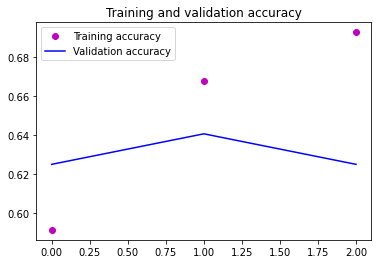

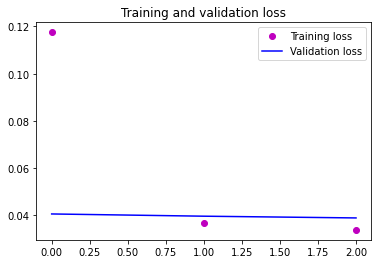

Validation Accuracy:0.66839998960495 
Validation Loss:0.03615553677082062


In [16]:
model, history, score = fit_model(model, train_dataset, X_val, y_val, batch_size_train, batch_size_validation, epochs)

# Learning curves
curves(history, epochs)
print('Validation Accuracy:{} \nValidation Loss:{}'.format(score[1] ,score[0]))

In [22]:
# Prediction
model.load_weights('/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/output/my_checkpoint3.ckpt')
Y_pred = model.predict(test_dataset)

In [25]:
testY_labels = test_dataset.labels
print(testY_labels)
print(len(testY_labels))

[ 0  0  0 ... 47 47 47]
40000


In [19]:
model.load_weights('/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/output/my_checkpoint3.ckpt')

loss, acc = model.evaluate(X_test, y_test)
print("loss: ", loss)
print("acc: ", acc)

1/1 [==============================] - 0s 172ms/step - loss: 0.0456 - accuracy: 0.5312
loss:  0.0456390380859375
acc:  0.53125


In [ ]:
# Tensorflow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('/home/azure/passion/AI/Category and Attribute Prediction Benchmark/dataset/output/my_checkpoint3.tflite', 'wb').write(tflite_model)